* * *
<pre> NYU Paris            <i> Machine Learning - Spring 2023 </i></pre>
* * *


<h1 align="center"> Lab: Anomaly detection  </h1>

<pre align="left"> March 22rd 2023               <i> Author: Guillaume Staerman </i></pre>
* * *



Several methods in machine learning can be used to detect fraud or anticipate system failures. While this is a standard -- but very unbalanced -- binary classification problem, it is very hard to find annotated data to perform supervised learning. Moreover, failures are by definition outliers of the general distribution of the data: It may not make any sense to try to "characterize" their distribution specially if new types of anomalies appear. For this reason, we focus in this lab on unsupervised methods for anomaly detection.

# Part I: Probability density estimation

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Consider the following random variable following a Gaussian (i.e normal) distribution with mean 0 and variance 1.

$$ X\sim \mathcal{N}(0, 1)$$

Its theoretical probability density function is given by:

$$f(x) = \frac{1}{\sqrt{2\pi} }\exp(-\frac{x^2}{2}). $$


### Question 1
Generate 1000 samples from the Gaussian distribution and visualize the histogram on 10 figures with an increasing number of bins. The density function should be overlayed on top to evaluate the quality of the histogram. 

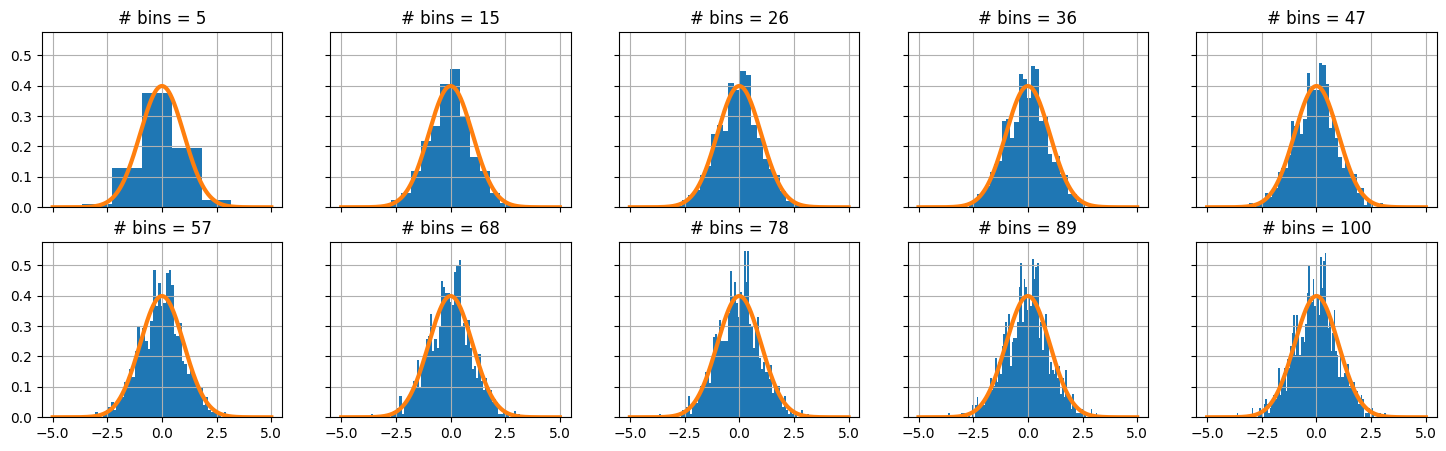

In [2]:
rng = np.random.default_rng(42)
X = rng.normal(size=(1000))
grid = np.linspace(-5, 5., 1000)
density = np.exp(- grid ** 2 / 2) / (2 * np.pi) ** 0.5

bins = np.linspace(5, 100, 10).astype(int)
f, axes = plt.subplots(2, 5, figsize=(18, 5), sharex=True, sharey=True)
for ax, bin_ in zip(axes.ravel(), bins):
    ax.hist(X, bins=bin_, density=True)
    ax.set_title(f"# bins = {bin_}")
    ax.plot(grid, density, lw=3)
    ax.grid(True)
plt.show()

### Question 2

Histograms approximate the density by counting the number of samples falling in a bin, regardless of where the sample falls withing that bin. To better approximate the density, one can instead count the samples but with a given weight: samples falling in the center of the bin should count more than samples on the edges of the same bin. This weighting can be decided by a Kernel function: enters the Kernel density estimator.

Compare (graphically) the density estimaton of KDE to that of a histogram. 


_Hints:
The Kernel density object can be fitted on some data X (n_samples, dimension):
`kde.fit(X)`
then evaluated on some points to obtain the logarithm of the density funciton values: `kde.score_samples(X_eval)`_
(i.e the log-likelihood).

In [4]:
from sklearn.neighbors import KernelDensity

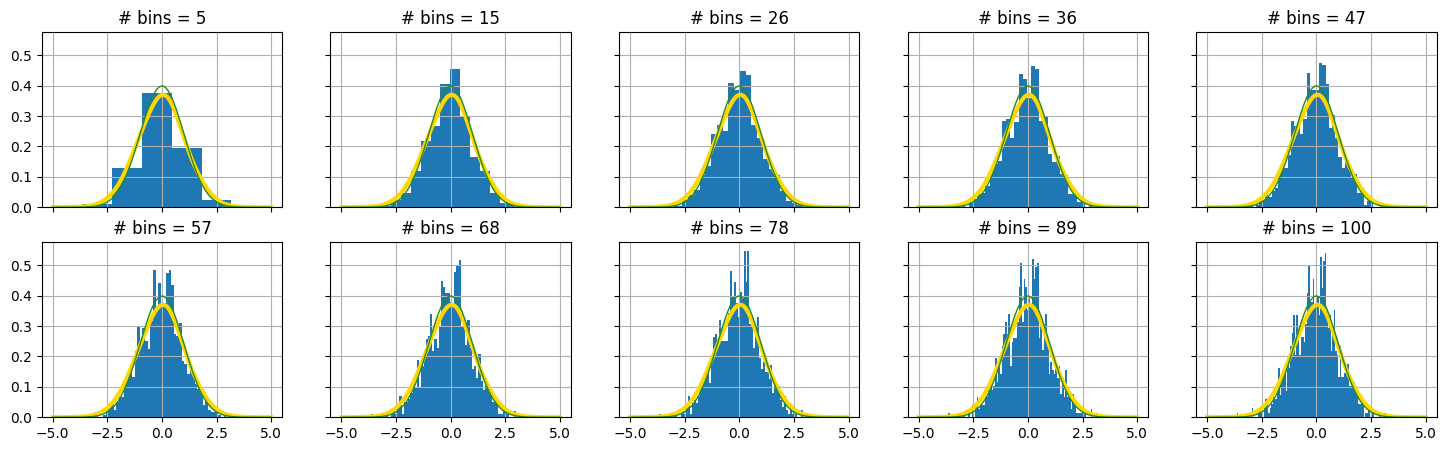

In [5]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X[:, None])

# obtain the log density
logdensity_kde = kde.score_samples(grid[:, None])
# transfer log density function values to actual density values
density_kde = np.exp(logdensity_kde)

bins = np.linspace(5, 100, 10).astype(int)
f, axes = plt.subplots(2, 5, figsize=(18, 5), sharex=True, sharey=True)
for ax, bin_ in zip(axes.ravel(), bins):
    ax.hist(X, bins=bin_, density=True)
    ax.set_title(f"# bins = {bin_}")
    ax.plot(grid, density_kde, color="gold", lw=3)
    ax.plot(grid, density, color="forestgreen", lw=1)
    ax.grid(True)
plt.show()

### Question 3
Contaminate the samples by adding very large values. How did their kde score change ? How can this log-likelihood score be used to detect outliers ?

(array([  1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   4.,   0.,   2.,
          6.,   6.,  11.,  20.,  35.,  58.,  89., 187., 579.]),
 array([-7.13354663, -6.82664734, -6.51974805, -6.21284876, -5.90594947,
        -5.59905017, -5.29215088, -4.98525159, -4.6783523 , -4.37145301,
        -4.06455372, -3.75765442, -3.45075513, -3.14385584, -2.83695655,
        -2.53005726, -2.22315797, -1.91625868, -1.60935938, -1.30246009,
        -0.9955608 ]),
 <BarContainer object of 20 artists>)

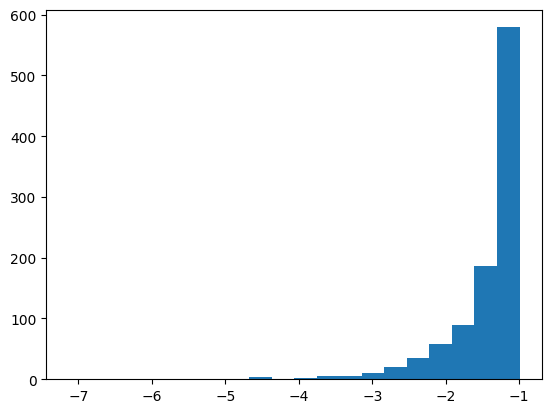

In [ ]:
X[0] = 1000.

kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X[:, None])

logdensity_kde = kde.score_samples(X[:, None])

plt.hist(logdensity_kde, bins=20)
# more near to 0 means more normal. More small means more abnormal.

In [8]:
X[np.where(logdensity_kde < -5)[0]]
# here has 3 data points' logdensity score less then -5, meaning they are anormalies
# here the manually changed 1000 si clearly one anormaly and the other two are relatively abnormal in our threhold of logdensity_kde < -5

array([1000.        ,    3.17885368,   -3.64841283])

### Question 4
We are now ready to move on to a 2-dimension setting. We generate some data:  
2D data anormaly detection

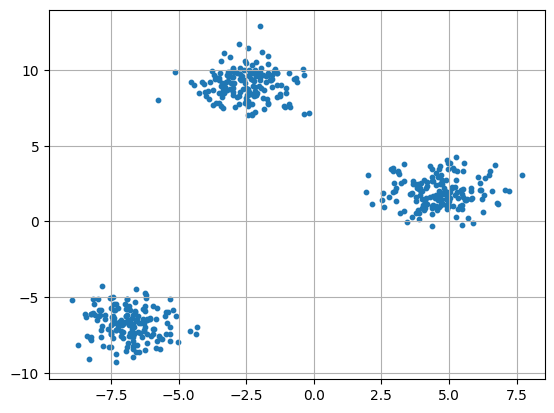

In [9]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_features=2, centers=3, n_samples=500,
                  random_state=42)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.grid()
plt.show()

The function `plot_logdensity` displays the density estimation contours.

In [12]:
def get_2d_grid(X):
    n_samples, n_features = X.shape
    X_range = np.zeros((n_features, 2))
    X_range[:, 0] = np.min(X, axis=0) - 1.
    X_range[:, 1] = np.max(X, axis=0) + 1.

    h = 0.1  # échelle de la grille
    x_min, x_max = X_range[0]
    y_min, y_max = X_range[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_logdensity(kde, X):
    xx, yy = get_2d_grid(X)
    grid = np.c_[xx.ravel(), yy.ravel()]
    scores = kde.score_samples(grid).reshape(xx.shape)
    plt.figure()
    z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) # on trace les level sets de oneclass svm
    plt.scatter(X[:, 0], X[:, 1], s=5)
    plt.colorbar(z)
    plt.title("Log-density")
    plt.show()

#### 2D log density visulaization

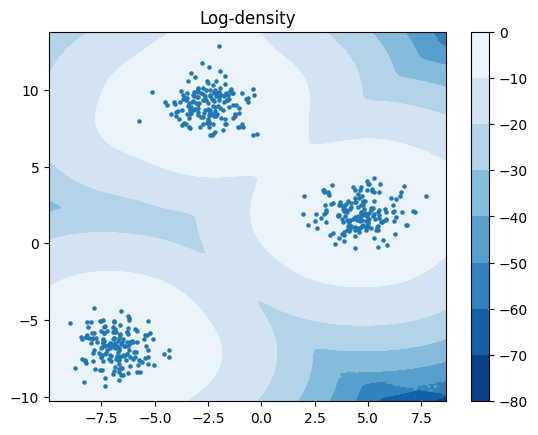

In [13]:
kde = KernelDensity(kernel='gaussian', bandwidth=1.)
kde.fit(X)
plot_logdensity(kde, X)

In [14]:
## figure left here for "spiking curiosity purposes"

We can visualize a specific contour of the density by providing a `levels` argument in `plt.contour`. Using this  code below.

<a list of 9 text.Text objects>

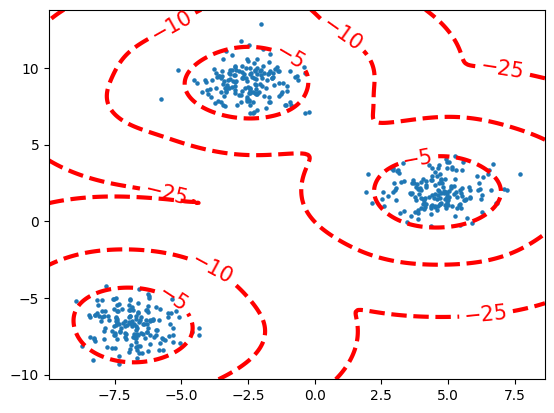

In [16]:
# visualize the contour
xx, yy = get_2d_grid(X)
grid = np.c_[xx.ravel(), yy.ravel()]
scores = kde.score_samples(grid).reshape(xx.shape)
somevalue = [-25, -10, -5]
plt.scatter(X[:, 0], X[:, 1], s=5)
c_0 = plt.contour(xx, yy, scores, levels=somevalue, colors='red', linewidths=3)
## add a label to this specific contour
plt.clabel(c_0, inline=1, fontsize=15)

The mquantiles function returns the value of the quantile q of some empirical distribution. Use `mquantiles` to decide an outlier threshold value and display its contour using the code above by adding it to `plot_logdensity` function. How does the contour change with the chose value ? 

In [17]:
from scipy.stats.mstats import mquantiles

logdensity_scores = kde.score_samples(X).ravel()
threshold = mquantiles(logdensity_scores, 0.02)

In [18]:
def plot_logdensity(X, bandwidth=1., quantile=0.01):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X)
    logdensity_scores = kde.score_samples(X)
    threshold = mquantiles(logdensity_scores, quantile)

    xx, yy = get_2d_grid(X)
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scores = kde.score_samples(grid).reshape(xx.shape)
    
    plt.figure()
    z = plt.contourf(xx, yy, grid_scores, cmap=plt.cm.Blues_r) # on trace les level sets de oneclass svm
    plt.scatter(X[:, 0], X[:, 1], s=5)
    plt.colorbar(z)
    c_0 = plt.contour(xx, yy, grid_scores, levels=[threshold[0]], colors='red', linewidths=3)
    plt.clabel(c_0, inline=1, fontsize=15, fmt={threshold[0]: str(quantile)})
    plt.title("Log-density")
    plt.show()


larger quantile makes the contours smaller, meaning that we considered the anormalies in a harder threhold, as a result, there will be more data points be considered as anormalies.  
In contrast, smaller quantile makes the contours larger, meaning that we considered the anormalies in a softer threhold, as a result, there will be less data points be considered as anormalies.

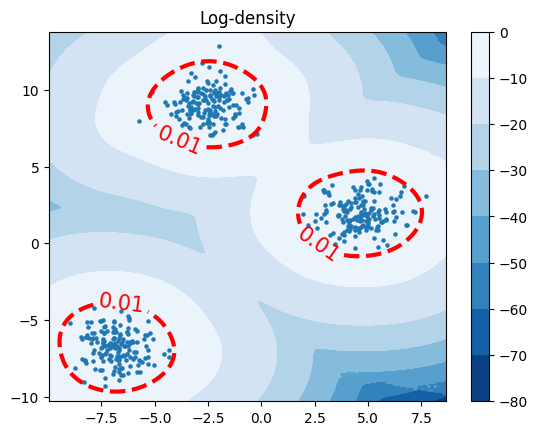

In [23]:
# using quantile of 0.01 of the given distribution of data to detect outliers
# the data outside of the quantile contour are anormalies
plot_logdensity(X, quantile=0.01)

# Part 2: OneClass SVM

The SVM intuition can be used for novelty detection even for unsupervised learning. The idea is to find a separation in a higher dimensional space that contains most of the data. Intuitively, using a Gaussian kernel for example, we are looking for the smallest hypersphere  that contains the data. This minimization with the flexibility of allowing some samples (outliers) to be out of the sphere, leads to an outlier detection model.

In [33]:
from sklearn.svm import OneClassSVM
# nu represent there are at most 5% of data can be considered as outliers
nu = 0.05  # regularization parameter controlling the max proportion of expected outliers
ocsvm = OneClassSVM(kernel = 'rbf', gamma = 'scale', nu = nu)
ocsvm.fit(X)

OneClassSVM(nu=0.05)

###  Question 5

Draw the frontier (separation) of the oneclass svm using `ocsvm.decision_function`. Use the predict function to get outliers detected by OCSVM and visualize them on top. 

In [34]:
y_pred = ocsvm.predict(X)
X_outliers = X[y_pred == -1]
X_normal = X[y_pred == 1]

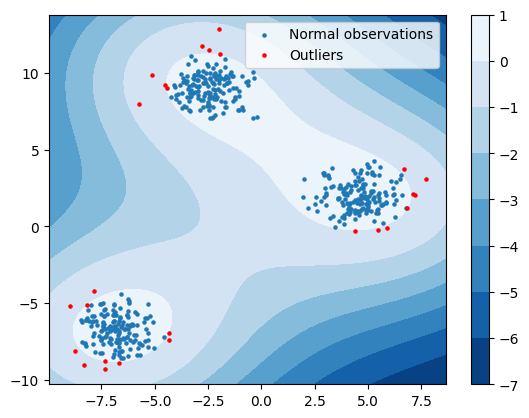

In [35]:
# the red dot represents the outliers
xx, yy = get_2d_grid(X)
grid = np.c_[xx.ravel(), yy.ravel()]
scores = ocsvm.decision_function(grid).reshape(xx.shape)
plt.figure()
z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) 
plt.scatter(X_normal[:, 0], X_normal[:, 1], s=5, label='Normal observations')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=5, c='r', label='Outliers')
plt.colorbar(z)
plt.legend()
plt.show()

### Question 6
Run the following cell. What can we say about the support vectors of the OCSVM ?




The support vectors in One-Class SVM are the data points that lie on or near the boundary between the normal region and the outlier region. 
- Many of the detected outliers are also support vectors, because they "push" the boundary outward.
- In my result, the number of outliers detected matches the number of red points shown in the plot, and these outliers are typically located at the edge of the data distribution.
- The support vectors are the most "informative" samples for the OCSVM. They determine the position and shape of the anomaly detection boundary, and many outliers are among or near the support vectors.

In [36]:
X_SV = X[ocsvm.support_] 
n_SV = len(X_SV)

n_outliers = len(X_outliers)
print(n_outliers)

26


### Question 7

What is the expected effect of the choice of `nu` ? `gamma`? Visualize the separation and the detected outliers in a large 2d plt.subplots where each parameter is modified along one of the subplots axes. 

- nu: **Controls the maximum proportion of data that can be classified as outliers.** The larger nu is, the more outliers are allowed, and the classification boundaries are tighter.
- gamma: **RBF kernel parameter that controls the width of the Gaussian kernel.** The larger gamma is, the more complex the model is and the more curved the classification boundaries are; the smaller gamma is, the smoother the classification boundaries are.
- **The larger gamma**: The more curved the separating hyperplanes, the more complex the model, and the more likely it is to overfit.
- **The smaller gamma**: The smoother the separating hyperplanes, the more likely it is to miss some edge outliers.

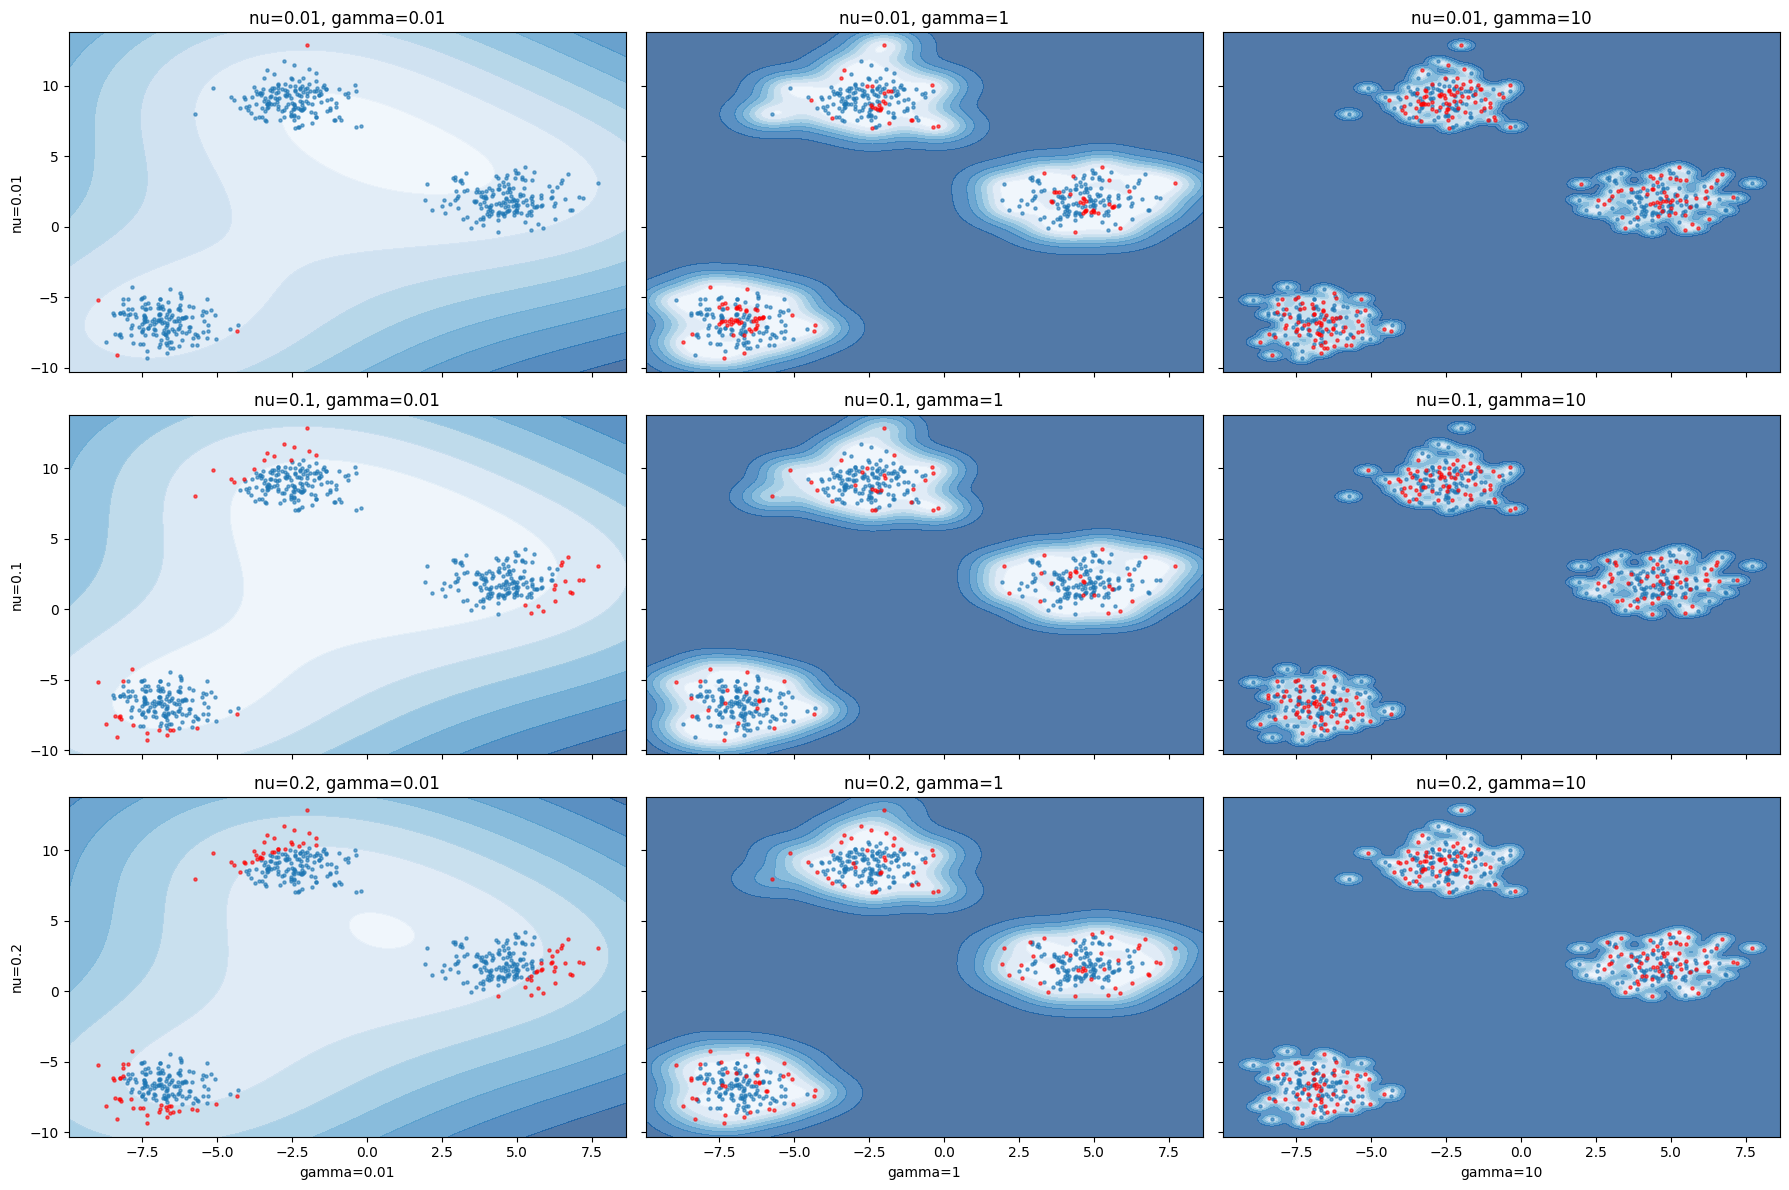

In [39]:
nus = [0.01, 0.1, 0.2]
gammas = [0.01, 1, 10]

fig, axes = plt.subplots(len(nus), len(gammas), figsize=(18, 12), sharex=True, sharey=True)

for i, nu in enumerate(nus):
    for j, gamma in enumerate(gammas):
        ocsvm = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        ocsvm.fit(X)
        y_pred = ocsvm.predict(X)
        X_outliers = X[y_pred == -1]
        X_normal = X[y_pred == 1]

        xx, yy = get_2d_grid(X)
        grid = np.c_[xx.ravel(), yy.ravel()]
        scores = ocsvm.decision_function(grid).reshape(xx.shape)

        ax = axes[i, j]
        z = ax.contourf(xx, yy, scores, cmap=plt.cm.Blues_r, alpha=0.7)
        ax.scatter(X_normal[:, 0], X_normal[:, 1], s=5, label='Normal', alpha=0.6)
        ax.scatter(X_outliers[:, 0], X_outliers[:, 1], s=5, c='r', label='Outlier', alpha=0.6)
        ax.set_title(f'nu={nu}, gamma={gamma}')
        if i == len(nus) - 1:
            ax.set_xlabel('gamma={}'.format(gamma))
        if j == 0:
            ax.set_ylabel('nu={}'.format(nu))

plt.tight_layout()
plt.show()

# Part 3: Isolation Forest

In [40]:
from sklearn.ensemble import IsolationForest

### Question 8

Use Isolation Forest on the data and draw contours of the IF scores. Is it equivalent to those of the density? Contours should be simlar to hyper-rectangle if the number of trees is low (<10), why ?

- No, the contours of Isolation Forest scores are not equivalent to those of the density estimation (such as KDE).
- Because **each tree is divided along the axis, when there are only a few trees, the divisions are not fine enough**, and the contours appear as rectangular blocks. When there are many trees, the divisions are finer, and the contours are smoother, but there is still a “blocky” appearance. 


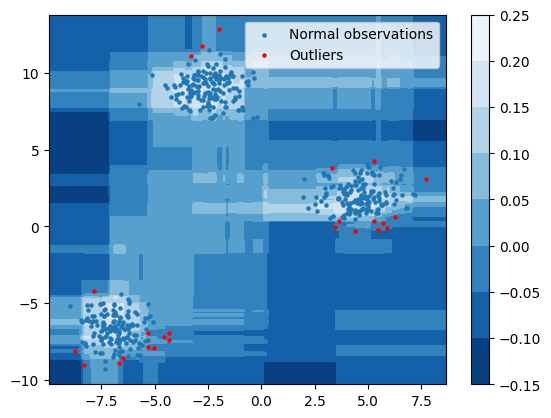

In [44]:
# seeting 100 random slicing tress and outlier propotion still 0.05 as nu.
IF = IsolationForest(n_estimators=5, contamination=0.05, random_state=42)
IF.fit(X)

y_pred = IF.predict(X)
X_outliers = X[y_pred == -1]
X_normal = X[y_pred == 1]

xx, yy = get_2d_grid(X)
grid = np.c_[xx.ravel(), yy.ravel()]
scores = IF.decision_function(grid).reshape(xx.shape)
plt.figure()
z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) 
plt.scatter(X_normal[:, 0], X_normal[:, 1], s=5, label='Normal observations')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=5, c='r', label='Outliers')
plt.colorbar(z)
plt.legend()
plt.show()

# Bonus Part ++ : Comparison of KDE, OCSVM, IF on real world data 

### Question 9

Compare these three algorithms on the dataset on the http dataset available http://odds.cs.stonybrook.edu/http-kddcup99-dataset/. Compare the accuracy of the algorithms with the roc curves and the computational time. 

In [13]:
import time
from sklearn.metrics import roc_curve, roc_auc_score

The link cannot be openned

#### Import data

In [14]:
Z, y_true = # to do

SyntaxError: invalid syntax (4294232930.py, line 1)

#### Perform algorithms and compute time

#### Display roc curves

In [ ]:
# Accuracy using the roc curves 

y_pred_IF = # to do
y_pred_OC = # to do
y_pred_kde = # to do

fpr, tpr, _ = roc_curve(y_true,  y_pred_IF)
auc = roc_auc_score(y_true,  y_pred_IF)
plt.plot(fpr,tpr, label="Isolation Forest, AUC="+str(auc))
fpr, tpr, _ = roc_curve(y_true,  y_pred_OC)
auc = roc_auc_score(y_true,  y_pred_OC)
plt.plot(fpr,tpr, label="One-Class SVM, AUC="+str(auc))
plt.plot(fpr,tpr)
fpr, tpr, _ = roc_curve(y_true,  y_pred_kde)
auc = roc_auc_score(y_true,  y_pred_kde)
plt.plot(fpr,tpr, label="KDE, AUC="+str(auc))
plt.plot(fpr,tpr)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Question 10:

Repeat this comparison with other datasets from http://odds.cs.stonybrook.edu. Try a high dimensional dataset such as the one here http://odds.cs.stonybrook.edu/speech-dataset/. What do you observe?

In [1]:
from scipy.io import loadmat

loadmat('http.mat')

In [5]:
import mat73
X = mat73.loadmat('http.mat')

In [10]:
X['X'].shape

(567498, 3)